In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
PRUNING_PATH = Path('./pruning/')

### Logs

In [2]:
tr_logs = pd.read_csv(PRUNING_PATH / f"train_logs_1.csv",index_col=0).sort_values('epoch')
tr_logs.loc["1_002"]

,epoch,train_loss,val_loss,early_stopping_counter
exp_id,,,,
1_002,0,0.925654,0.602948,0
1_002,1,0.789622,0.560538,0
1_002,2,0.780392,0.562075,1
1_002,3,0.754748,0.552242,0
1_002,4,0.745136,0.565432,1
1_002,5,0.729436,0.553949,2
1_002,6,0.723137,0.560016,3
1_002,7,0.713479,0.553447,4
1_002,8,0.704134,0.559175,5


In [5]:
pl_df = pd.read_csv(PRUNING_PATH/'pruning_logs.csv', index_col = 0)
pl_df

,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,d_layers,d_ff,model
1_004,1,4,32,32,MS,2,pruning,0.670543,2,128,1,64,PatchTST
1_005,1,5,32,32,MS,2,pruning,0.755248,2,256,1,128,Nonstationary_Transformer
1_006,1,6,32,32,MS,2,pruning,0.681680,2,128,1,64,iTransformer
1_008,1,8,32,32,MS,2,pruning,0.789852,2,128,1,64,DLinear
1_001,1,1,32,32,MS,4,pruning,0.640780,2,128,1,64,Transformer
1_007,1,7,32,32,MS,4,pruning,0.668349,2,128,1,64,LSTM
1_003,1,3,32,32,MS,6,pruning,0.608219,2,128,1,64,Pyraformer
1_002,1,2,32,32,MS,10,early_stopping,0.552242,2,128,1,64,Crossformer


In [10]:
"pruning" in pl_df[pl_df['pr_id']==1]['death'].unique()

True

In [5]:
pl_df = pd.read_csv(PRUNING_PATH/'testing_logs.csv', index_col = 0)
pl_df

,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,...,d_ff,dropout,wd,learning_rate,mae,mse,mape,mspe,rmse,fde
18_1,18,1,32,32,MS,2,pruning,0.824411,1,512,...,256,0.1,0.05,0.0005,2.951652,16.564585,inf,inf,4.069961,5.970537
18_2,18,2,32,32,MS,2,pruning,0.803254,1,512,...,256,0.1,0.10,0.0005,2.681269,16.273001,inf,inf,4.033981,5.849078
18_3,18,3,32,32,MS,5,epoch_budget,0.742771,1,512,...,256,0.2,0.05,0.0005,2.704793,15.490880,inf,inf,3.935846,5.666344
18_4,18,4,32,32,MS,1,pruning,0.839573,1,512,...,256,0.2,0.10,0.0005,2.830353,16.736494,inf,inf,4.091026,6.056652
18_5,18,5,32,32,MS,1,pruning,0.829448,1,512,...,256,0.5,0.05,0.0005,2.817096,17.016407,inf,inf,4.125095,5.923249
18_6,18,6,32,32,MS,1,pruning,0.842796,1,512,...,256,0.5,0.10,0.0005,2.905861,17.670755,inf,inf,4.203660,5.920979
19_3,19,3,32,32,MS,5,epoch_budget,0.742771,1,512,...,256,0.2,0.05,0.0005,2.704793,15.490880,inf,inf,3.935846,5.666344
20_3,20,3,32,32,MS,5,epoch_budget,0.742771,1,512,...,256,0.2,0.05,0.0005,2.704793,15.490880,inf,inf,3.935846,5.666344


### LR

#### Cosine with restart

In [6]:
class CosineAnnealingWithRestarts:
    """
    Implements cosine annealing with warm restarts
    After each pruning event, the LR cycle is restarted
    """
    
    def __init__(self, optimizer, cycle_length, initial_lr=0.01, min_lr=0.0001, restart_factor=1.0):
        """
        Args:
            optimizer: PyTorch optimizer
            cycle_length: Length of each cosine cycle (typically n_steps_per_prune)
            initial_lr: Starting learning rate
            min_lr: Minimum learning rate at the bottom of the cycle
            restart_factor: Factor to adjust cycle amplitude after restart (1.0 means same range)
        """
        # self.optimizer = optimizer
        self.cycle_length = cycle_length
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.restart_factor = restart_factor
        self.current_cycle = 0
        self.step_in_cycle = 0
        self.current_max_lr = initial_lr
        
        # Set initial learning rate
        # for param_group in self.optimizer.param_groups:
        #     param_group['lr'] = initial_lr
    
    def step(self):
        """Updates learning rate based on position in cosine cycle"""
        # Calculate position in cycle
        cycle_progress = self.step_in_cycle / self.cycle_length
        
        # Cosine function scaled to desired range
        cosine_factor = 0.5 * (1 + np.cos(np.pi * cycle_progress))
        lr = self.min_lr + (self.current_max_lr - self.min_lr) * cosine_factor
        
        # Apply learning rate
        # for param_group in self.optimizer.param_groups:
        #     param_group['lr'] = lr
            
        self.step_in_cycle += 1
        
        # Check if we need to restart cycle
        if self.step_in_cycle >= self.cycle_length:
            self.restart_cycle()
        
        return lr
    
    def restart_cycle(self):
        """Restart the cosine cycle, potentially with adjusted parameters"""
        self.step_in_cycle = 0
        self.current_cycle += 1
        
        # Optionally adjust maximum learning rate for next cycle
        self.current_max_lr = self.initial_lr * (self.restart_factor ** self.current_cycle)


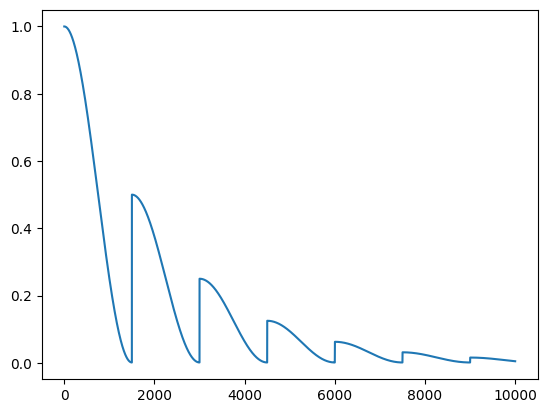

In [9]:
scheduler = CosineAnnealingWithRestarts(None,
                                        cycle_length=1500,
                                        initial_lr=1,
                                        min_lr=0.001,
                                        restart_factor=0.5)
lr = []
for i in range(10000):
    lr.append(scheduler.step())
plt.plot(lr)

#### Cosine with restart and warmup

In [15]:
def adjust_learning_rate_pruning(optimizer, 
                                 max_lr,
                                 min_lr,
                                 epoch, 
                                 pruning_epoch, 
                                 n_iter, 
                                 n_iter_per_epoch, 
                                 warmup_fraction : float = 0.25,
                                 restart_factor : int = 0.5):
    """
    Adjust the learning rate with cycle for pruning scenario
    """
    cycle_length = pruning_epoch * n_iter_per_epoch
    step_in_cycle = (epoch % pruning_epoch)*n_iter_per_epoch + n_iter
    warmup_steps = warmup_fraction * cycle_length
    
    n_cycles = epoch // pruning_epoch
    rest_max_lr = max_lr * restart_factor ** n_cycles
    rest_min_lr = min_lr * restart_factor ** n_cycles
    
    if step_in_cycle < warmup_steps :
        warmup_progress = step_in_cycle / warmup_steps
        lr = rest_min_lr + (rest_max_lr - rest_min_lr) * warmup_progress
    else :
        cosine_steps = cycle_length - warmup_steps
        cosine_progress = (step_in_cycle - warmup_steps) / cosine_steps
        cosine_factor = 0.5 * (1 + np.cos(np.pi * cosine_progress))
        lr = rest_min_lr + (rest_max_lr - rest_min_lr) * cosine_factor   
    return lr

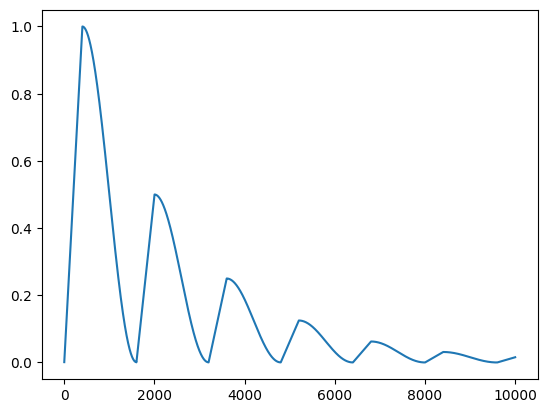

In [16]:
lrs = []
for i in range (10000):
    epoch = i // 400
    n_iter = i % 400
    lr = adjust_learning_rate_pruning(None, 1, 0.001, epoch = epoch, pruning_epoch=4,n_iter = n_iter, n_iter_per_epoch=400)
    lrs.append(lr)
plt.plot(lrs);

### Curves

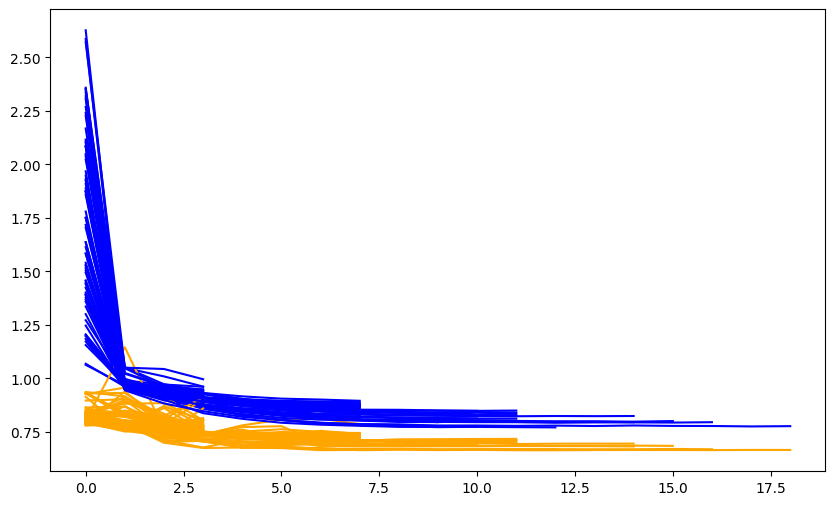

In [23]:
pr_id = 13
fig, ax = plt.subplots(1,1,figsize = (10,6))
for f in os.listdir(PRUNING_PATH / 'learning_curves'):
    if int(f.split('_')[0]) == pr_id :
        if f.split('_')[2] == 'train':
            color = 'blue'
        else :
            color = 'orange'
        curve = np.load(PRUNING_PATH / 'learning_curves' / f)
        ax.plot(curve, color = color);

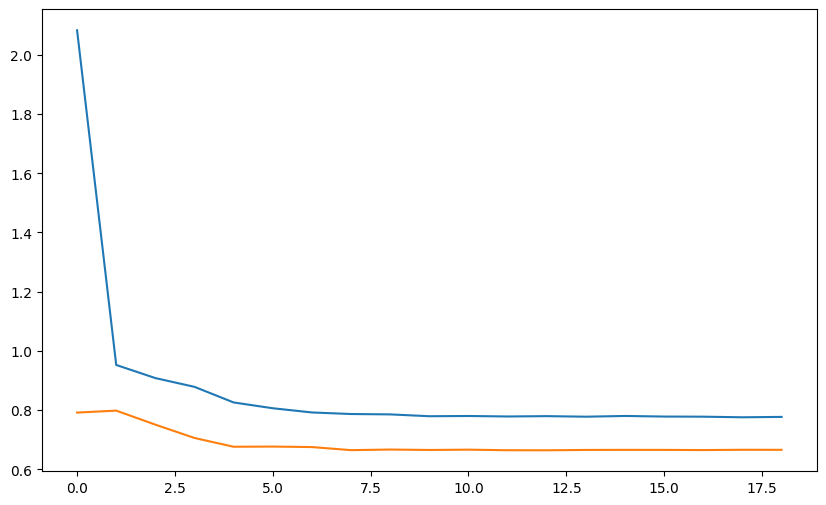

In [24]:
id = '13_18'

fig, ax = plt.subplots(1,1,figsize = (10,6))
train_loss = np.load(PRUNING_PATH / 'learning_curves' / f'{id}_train_loss.npy')
val_loss = np.load(PRUNING_PATH / 'learning_curves' / f'{id}_val_loss.npy')
ax.plot(train_loss);
ax.plot(val_loss);

### Exp management

In [23]:
base_exps = [{'id' : f"id_{i}",'values':np.random.randint(0,10, size=(1,)), 'factor':np.round(np.random.randint(50,100)/100,3), 'alive': True} for i in range(20)]
for exp in base_exps :
    exp['th_values'] = [exp['values'][0] * exp['factor']** i for i in range(20)]
base_exps[0]

{'id': 'id_0',
 'values': array([7]),
 'factor': 0.94,
 'alive': True,
 'th_values': [7.0,
  6.58,
  6.1852,
  5.814087999999999,
  5.465242719999999,
  5.137328156799998,
  4.829088467391998,
  4.539343159348478,
  4.266982569787569,
  4.010963615600315,
  3.7703057986642956,
  3.5440874507444375,
  3.3314422036997713,
  3.131555671477785,
  2.9436623311891177,
  2.7670425913177707,
  2.601020035838704,
  2.444958833688382,
  2.2982613036670787,
  2.160365625447054]}

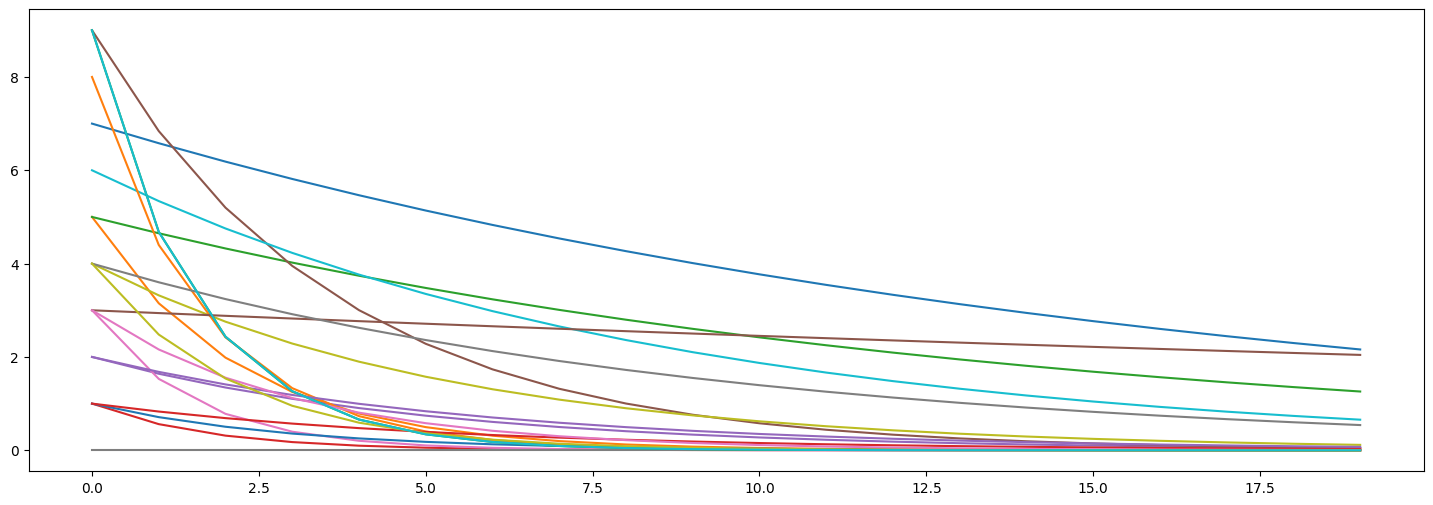

In [24]:
fig, ax = plt.subplots(1,1,figsize = (18,6))
for exp in base_exps :
    ax.plot(exp['th_values'])

In [ ]:
exps = base_exps.copy()
pruning_steps = 4
max_epochs = 20
pruning_factor = 0.5
n_iter = max_epochs // pruning_steps
for iter in range(n_iter):
    scores = []
    for exp in exps :
        for k in range(pruning_steps):
            new_value = exp['values'][-1] * exp['factor'] if exp['alive'] else np.nan
            exp['values'] = np.append(exp['values'], new_value)
        scores.append(exp['values'][-1])
    scs = pd.Series(scores, index = [exp['id'] for exp in exps])
    scs = scs.sort_values(ascending = False)
    n_exp_to_keep = int(scs.dropna().shape[0] * pruning_factor)
    keep_thres = scs.iloc[n_exp_to_keep]
    print(f"Iter n° {iter + 1} - threshold = {keep_thres:.2e}")
    for exp in exps :
        if exp['values'][-1] < keep_thres :
            exp['alive'] = False
            print(f"    killing exp {exp['id']} with a score of {exp['values'][-1]:.2e}")
scs

Iter n° 1 - threshold = 7.88e-01
    killing exp id_3 with a score of 9.83e-02
    killing exp id_6 with a score of 2.03e-01
    killing exp id_7 with a score of 0.00e+00
    killing exp id_10 with a score of 2.54e-01
    killing exp id_11 with a score of 7.32e-01
    killing exp id_12 with a score of 6.58e-01
    killing exp id_13 with a score of 4.75e-01
    killing exp id_18 with a score of 5.91e-01
    killing exp id_19 with a score of 6.58e-01
10 0.78764805
Iter n° 2 - threshold = 1.00e+00
    killing exp id_1 with a score of 1.24e-01
    killing exp id_4 with a score of 4.09e-01
    killing exp id_8 with a score of 9.01e-01
    killing exp id_14 with a score of 4.96e-01
    killing exp id_16 with a score of 2.17e-01
5 1.0017313087094786
Iter n° 3 - threshold = 1.48e+00
    killing exp id_5 with a score of 3.34e-01
    killing exp id_17 with a score of 1.13e+00
3 1.4819424213915733
Iter n° 4 - threshold = 1.57e+00
    killing exp id_9 with a score of 9.30e-01
2 1.565659008540007
I

id_0     2.030744
id_15    2.002824
id_2     1.171194
id_1          NaN
id_3          NaN
id_4          NaN
id_5          NaN
id_6          NaN
id_7          NaN
id_8          NaN
id_9          NaN
id_10         NaN
id_11         NaN
id_12         NaN
id_13         NaN
id_14         NaN
id_16         NaN
id_17         NaN
id_18         NaN
id_19         NaN
dtype: float64

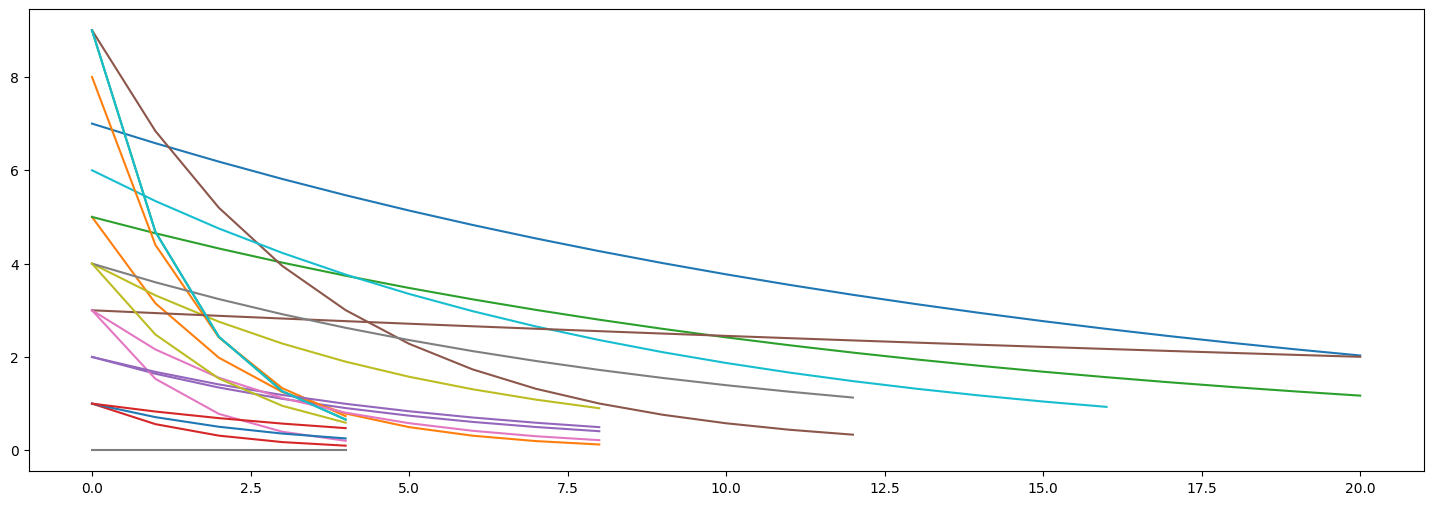

In [26]:
fig, ax = plt.subplots(1,1,figsize = (18,6))
for exp in exps :
    ax.plot(exp['values'])